In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 7.0 MB/s 
     |████████████████████████████████| 58 kB 7.5 MB/s 
     |████████████████████████████████| 376 kB 57.2 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=60a35da79e12a2f36b8118def27edb76597c309eb5377d126242aa3187376015
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=0a9080c6d885a52359aa8300ba6cfe9a67a7b429c3448db58efd9fc8db24358d
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

In [4]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Segmentation_DL_data')

In [5]:
!wget -c https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py

--2022-09-25 19:42:14--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2022-09-25 19:42:15 (36.6 MB/s) - ‘helper.py’ saved [2813/2813]



In [6]:
def show_image(image,mask,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

In [7]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [88]:
CSV_FILE = '/content/drive/MyDrive/Colab Notebooks/Segmentation_DL_data/train_gl.csv'
DATA_DIR ='/content/drive/MyDrive/Colab Notebooks/'

DEVICE = 'cuda'
EPOCHS = 300
LR = 0.001
IMG_SIZE = (128,224)
BATCH_SIZE = 3

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [61]:
df = pd.read_csv(CSV_FILE)
df.head

<bound method NDFrame.head of                                                masks  \
0  /content/drive/MyDrive/Colab Notebooks/Segment...   
1  /content/drive/MyDrive/Colab Notebooks/Segment...   
2  /content/drive/MyDrive/Colab Notebooks/Segment...   
3  /content/drive/MyDrive/Colab Notebooks/Segment...   
4  /content/drive/MyDrive/Colab Notebooks/Segment...   
5  /content/drive/MyDrive/Colab Notebooks/Segment...   
6  /content/drive/MyDrive/Colab Notebooks/Segment...   
7  /content/drive/MyDrive/Colab Notebooks/Segment...   
8  /content/drive/MyDrive/Colab Notebooks/Segment...   

                                              images  
0  /content/drive/MyDrive/Colab Notebooks/Segment...  
1  /content/drive/MyDrive/Colab Notebooks/Segment...  
2  /content/drive/MyDrive/Colab Notebooks/Segment...  
3  /content/drive/MyDrive/Colab Notebooks/Segment...  
4  /content/drive/MyDrive/Colab Notebooks/Segment...  
5  /content/drive/MyDrive/Colab Notebooks/Segment...  
6  /content/drive/MyDriv

In [62]:
row = df.iloc[1]

In [63]:
image_path = row.images 
mask_path = row.masks 

In [ ]:
# import os
# path = "/content/drive/MyDrive/Colab Notebooks/Segmentation_DL_data/Ground_Truth/1.png"
# if os.path.exists(path):
#   img = cv2.imread(path)
# else:
#   print("Path does not exist:", path)

# /content/drive/MyDrive/Colab Notebooks/Segmentation_DL_data/Ground_Truth/1.png

In [64]:

image = cv2.imread(image_path) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

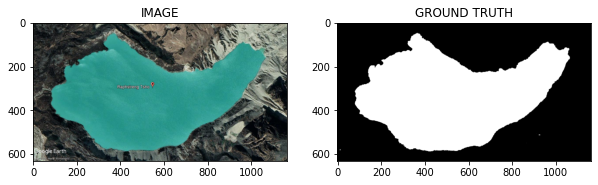

In [65]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [89]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [67]:
import albumentations as A

In [90]:
def get_train_augs():
  return A.Compose([
      A.Resize(128, 224),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
                    
                    ])

def get_valid_augs():
  return A.Compose([
      A.Resize(128, 224),                    
                    ])

In [69]:
from torch.utils.data import Dataset

In [91]:
class SegmentationDataset(Dataset):


  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations 

  def __len__(self):
    return len(self.df) 

  def __getitem__(self, idx):


    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) 
    mask = np.expand_dims(mask, axis = -1) 

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask) 
      image = data['image'] 
      mask = data['mask'] 

    image = np.transpose(image, (2,0,1)).astype(np.float32) 
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255
    mask = torch.round(torch.Tensor(mask) / 255) 

    return image, mask 

In [92]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [93]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 7
Size of Validset : 2


In [73]:
import matplotlib.image as mpi
import matplotlib.pyplot as plt
%matplotlib inline

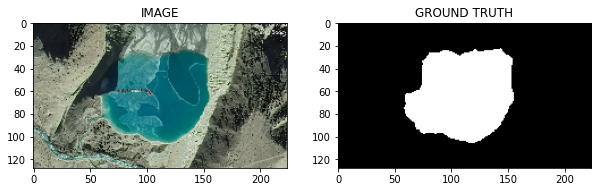

In [74]:
idx = 6

image, mask = trainset[idx]
show_image(image, mask)

In [75]:
from torch.utils.data import DataLoader 

In [94]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle =True) 
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [95]:
print(f'total no. of batches in tl : {len(trainloader)}') 
print(f'total no. of batches in vl : {len(validloader)}')

total no. of batches in tl : 3
total no. of batches in vl : 1


In [96]:
for image, mask in trainloader:
  break

  print(f'One batch image shape: {image.shape}') 
  print(f'One batch mask shape: {mask.shape}') 

In [79]:
from torch import nn
import segmentation_models_pytorch as smp 
from segmentation_models_pytorch.losses import DiceLoss 

In [97]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [98]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

In [99]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader): 
    images = images.to(DEVICE) 
    masks = masks.to(DEVICE) 

    optimizer.zero_grad() 
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step() 

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [100]:
def eval_fn(data_loader, model, optimizer):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader): 
      images = images.to(DEVICE) 
      masks = masks.to(DEVICE) 

      logits, loss = model(images, masks)
    
      total_loss += loss.item()

  return total_loss / len(data_loader)

In [101]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [102]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model, optimizer)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Saved-Model")
    best_valid_loss = valid_loss

  print(f"Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)")

100%|██████████| 1/1 [00:00<00:00, 15.49it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.61it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.72it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.05it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.96it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.41it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.79it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.80it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.02it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.73it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.89it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.74it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 14.75it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.79it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.57it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.45it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.86it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.91it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.91it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.70it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 14.58it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.20it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.39it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.52it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.41it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.74it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.11it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.87it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.31it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.28it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.62it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 14.26it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.85it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.88it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.94it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.23it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.16it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.80it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.07it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.39it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.78it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.81it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Saved-Model
Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 14.01it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.35it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.53it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.42it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.67it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.82it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.41it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.18it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.22it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.03it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.93it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.62it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.34it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.61it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 14.60it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.53it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.90it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.28it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.59it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.93it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.28it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.80it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.38it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.62it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.36it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.45it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.40it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.43it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.62it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.45it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 14.62it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.50it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.52it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.38it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.09it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.39it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.53it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.76it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.62it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.30it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.97it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.31it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.08it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.53it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.78it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.74it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.94it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.89it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.95it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.83it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.64it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.70it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.15it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.09it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.19it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 14.95it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.64it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.51it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.02it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.10it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.14it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.48it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.53it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.36it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 14.93it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.11it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.72it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.79it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.96it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 14.58it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.54it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.82it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.28it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.63it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.73it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 13.97it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.40it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.23it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.92it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.00it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.75it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.09it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 14.70it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.67it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.78it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.17it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.61it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.04it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.86it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.27it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.56it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.11it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.83it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.34it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.08it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.08it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.08it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.53it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.86it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.36it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.81it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.98it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.00it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.88it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.44it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.65it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.58it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 16.16it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.68it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.93it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 14.92it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.49it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.86it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 15.52it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 13.71it/s]


Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


100%|██████████| 1/1 [00:00<00:00, 14.95it/s]

Epoch : (i+1) Train_loss : (train_loss) Valid_loss: (valid_loss)


In [103]:
idx = 1

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C,H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

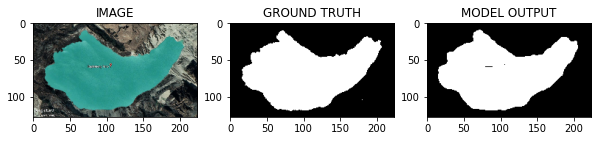

In [104]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))